In [1]:
#pip install xgboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error

import xgboost as xgb

In [3]:
df = pd.read_csv('PJME_hourly.csv')
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [4]:
# converting to datetime format
df['Datetime'] = pd.to_datetime(df['Datetime'])

In [5]:
# setting date as index
df = df.set_index('Datetime')

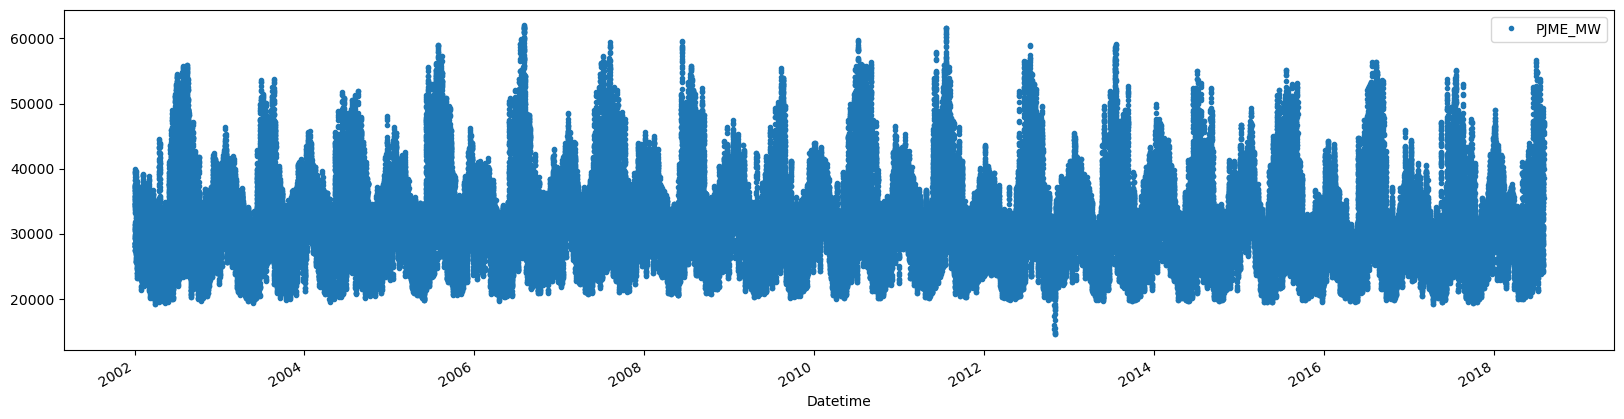

In [6]:
df.plot(figsize = (20,5),
        style = '.')
plt.show()

## Spotting Outliers

<AxesSubplot:ylabel='Frequency'>

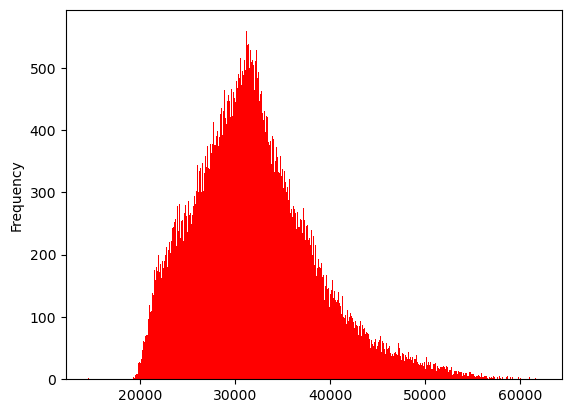

In [7]:
df['PJME_MW'].plot(kind = 'hist', bins=1000, color = 'red')

<AxesSubplot:xlabel='Datetime'>

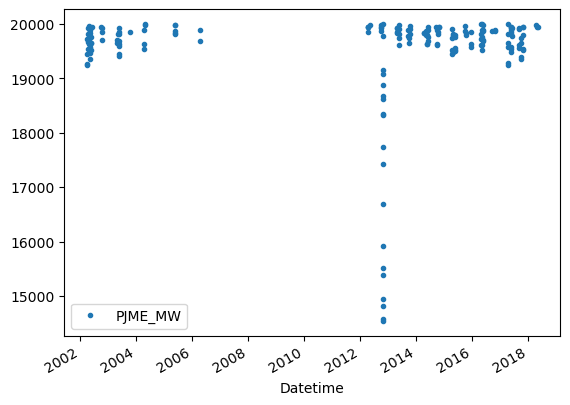

In [8]:
df.loc[df['PJME_MW']<19999].plot(style = '.')

<AxesSubplot:xlabel='Datetime'>

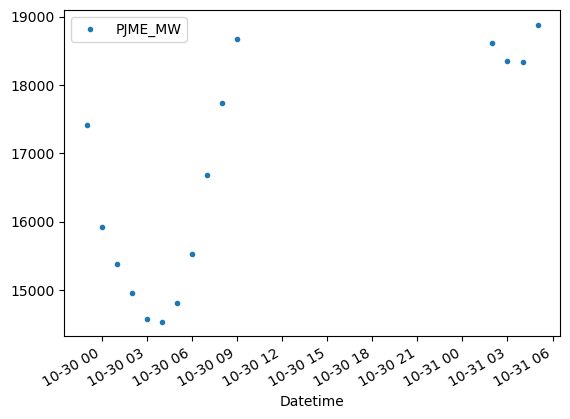

In [9]:
# outliers majorly spotted below 19000
df.loc[df['PJME_MW']<19000].plot(style = '.')

In [10]:
# choosing data that has values greater than 19000
df1 = df.loc[df['PJME_MW']>19000]

In [11]:
train = df1.loc[df1.index < '1-1-2015']
test = df1.loc[df1.index >= '1-1-2015']

[]

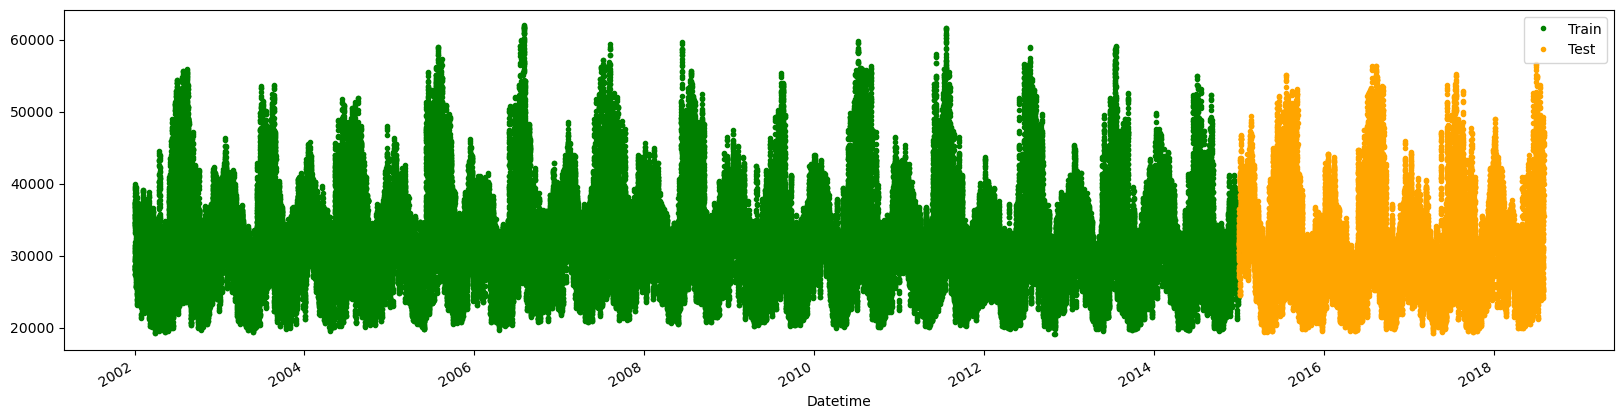

In [12]:
fig, ax = plt.subplots(figsize = (20,5))
train.plot(ax = ax, style = '.', color= 'green', label = 'Train')
test.plot(ax = ax, style = '.', color= 'orange', label = 'Test')
ax.legend(['Train', 'Test'])
ax.plot()

In [13]:
def features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df2 = features(df1)

<AxesSubplot:>

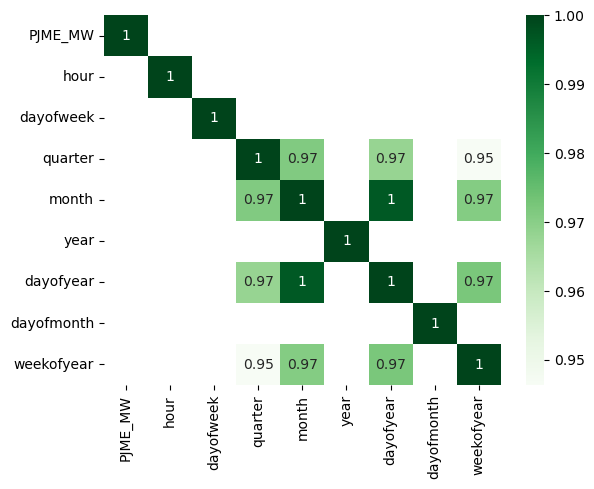

In [14]:
cor = df2.corr()
cor = cor[(cor>0.5)]
sns.heatmap(cor, annot=True, cmap='Greens')

<AxesSubplot:xlabel='month', ylabel='PJME_MW'>

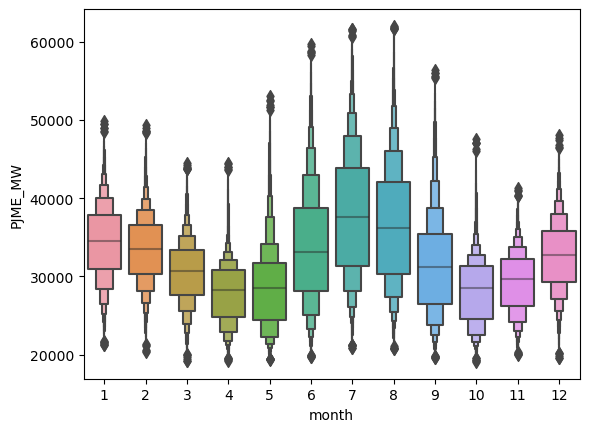

In [15]:
sns.boxenplot(data= df2, x= 'month', y='PJME_MW')

<AxesSubplot:xlabel='hour', ylabel='PJME_MW'>

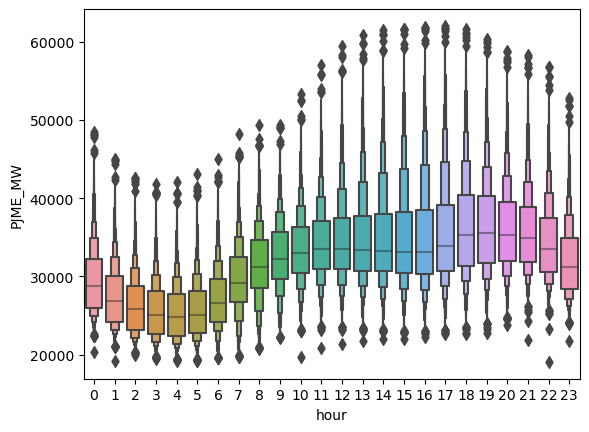

In [16]:
sns.boxenplot(data = df2, x= 'hour', y= 'PJME_MW')

## Time Series Data Split and Cross-Validation

In [17]:
from sklearn.model_selection import TimeSeriesSplit

timess = TimeSeriesSplit(n_splits=5, 
                         test_size=24*365*1,  # amount of time to be forecasted
                         gap=24)  # gap between training and validation set
df2 = df2.sort_index()

[]

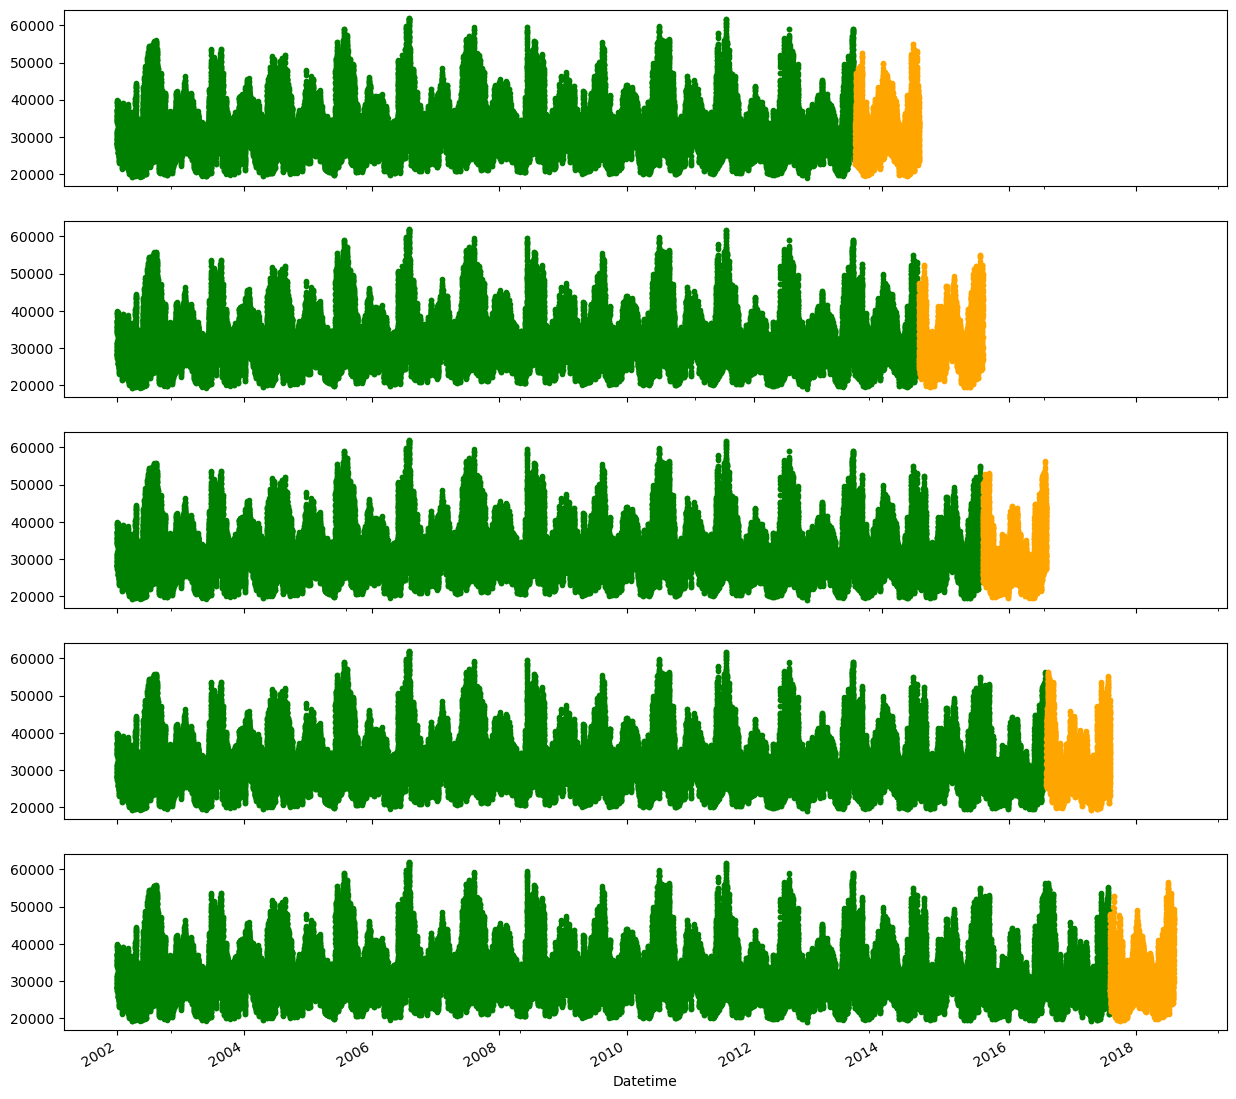

In [18]:
# testing five years independently from each other
fig, idx = plt.subplots(5, 1, figsize = (15,15), sharex= True)

folds=0
for train_index, val_index in timess.split(df2):
    train = df2.iloc[train_index]
    test = df2.iloc[val_index]
    train['PJME_MW'].plot(ax = idx[folds], style = '.', color= 'green', label = 'Train')
    test['PJME_MW'].plot(ax = idx[folds], style = '.', color= 'orange', label = 'Test')
    folds += 1
plt.plot()
    

In [19]:
# adding lags upto 3 years
def lags(df):
    target = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target)
    return df

In [20]:
lagged_df = lags(df2)

## Cross-Validation

In [21]:
timess = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
timedata = df2.sort_index()

# cross-validation time series data
fold = 0
preds = []
scores = []
for train_index, val_index in timess.split(timedata):
    train = timedata.iloc[train_index]
    test = timedata.iloc[val_index]

    train = features(train)
    test = features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'PJME_MW'
    # adding features to train and test
    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]
    # training model
    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = mean_absolute_percentage_error(y_test, y_pred)
    scores.append(score)

[19:27:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32732.50147	validation_1-rmse:31956.66494
[100]	validation_0-rmse:12532.10915	validation_1-rmse:11906.70125
[200]	validation_0-rmse:5739.78666	validation_1-rmse:5352.86754
[300]	validation_0-rmse:3868.29390	validation_1-rmse:3891.32148
[400]	validation_0-rmse:3428.85875	validation_1-rmse:3753.95996
[456]	validation_0-rmse:3349.18480	validation_1-rmse:3761.64093
[19:27:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32672.16154	validation_1-rmse:32138.88680
[100]	validation_0-rmse:12513.25338	validation_1-rmse:12222.97626
[200]	validation_0-rmse:5755.14393	validation_1-rmse:564

In [22]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 0.0849
Fold scores:[0.08565573866995307, 0.07429025201472572, 0.08412025591360958, 0.0898365388935836, 0.09038623726141798]


In [23]:
# retraining with new estimator value
df = features(df2)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'PJME_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[19:28:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32403.88753
[100]	validation_0-rmse:12426.44700
[200]	validation_0-rmse:5752.69704
[300]	validation_0-rmse:3970.08787
[400]	validation_0-rmse:3569.37848
[499]	validation_0-rmse:3454.55122


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

## Predicting the Future
To predict future data, you need to create a skeleton dataframe which can provide the model to relate to its pattern. This can be generated by adding features i.e., hours, year, month and lags

In [24]:
# creating a skeleton dataframe and concating to the whole data
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df2['isFuture'] = False
df_and_future = pd.concat([df2, future_df])
df_and_future = features(df_and_future)  # adding features (day, month, year)
df_and_future = lags(df_and_future)  # adding lags

In [25]:
df_and_future.query('isFuture')

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,isFuture
2018-08-03 00:00:00,NaN,0,4,3,8,2018,215,3,31,33539.0,32094.0,31695.0,True
2018-08-03 01:00:00,NaN,1,4,3,8,2018,215,3,31,30781.0,29503.0,29128.0,True
2018-08-03 02:00:00,NaN,2,4,3,8,2018,215,3,31,29015.0,27712.0,27373.0,True
2018-08-03 03:00:00,NaN,3,4,3,8,2018,215,3,31,27884.0,26535.0,26233.0,True
2018-08-03 04:00:00,NaN,4,4,3,8,2018,215,3,31,27223.0,25870.0,25643.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,31,31,46912.0,39352.0,40243.0,True
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,31,31,45985.0,38699.0,39183.0,True
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,31,31,44094.0,37346.0,37759.0,True
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,31,31,40666.0,34555.0,34641.0,True


In [26]:
pred_future_data = df_and_future.query('isFuture')

In [27]:
pred_future_data['PJME_MW'] = reg.predict(pred_future_data[FEATURES])

/var/folders/98/4w5bzj557j733_gyzdw052200000gn/T/ipykernel_12217/4216000322.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_future_data['PJME_MW'] = reg.predict(pred_future_data[FEATURES])


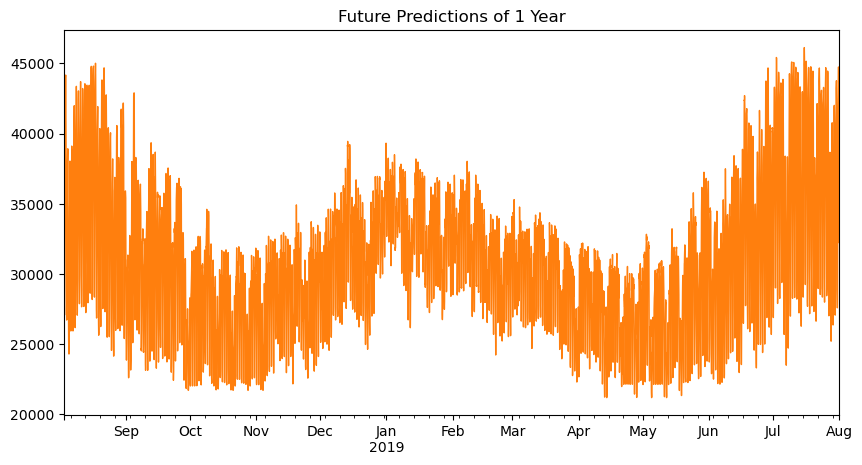

In [28]:
color_pal = sns.color_palette()
pred_future_data['PJME_MW'].plot(figsize=(10, 5),
                               color=color_pal[1],
                               ms=1,
                               lw=1,
                               title='Future Predictions of 1 Year')
plt.show()

[]

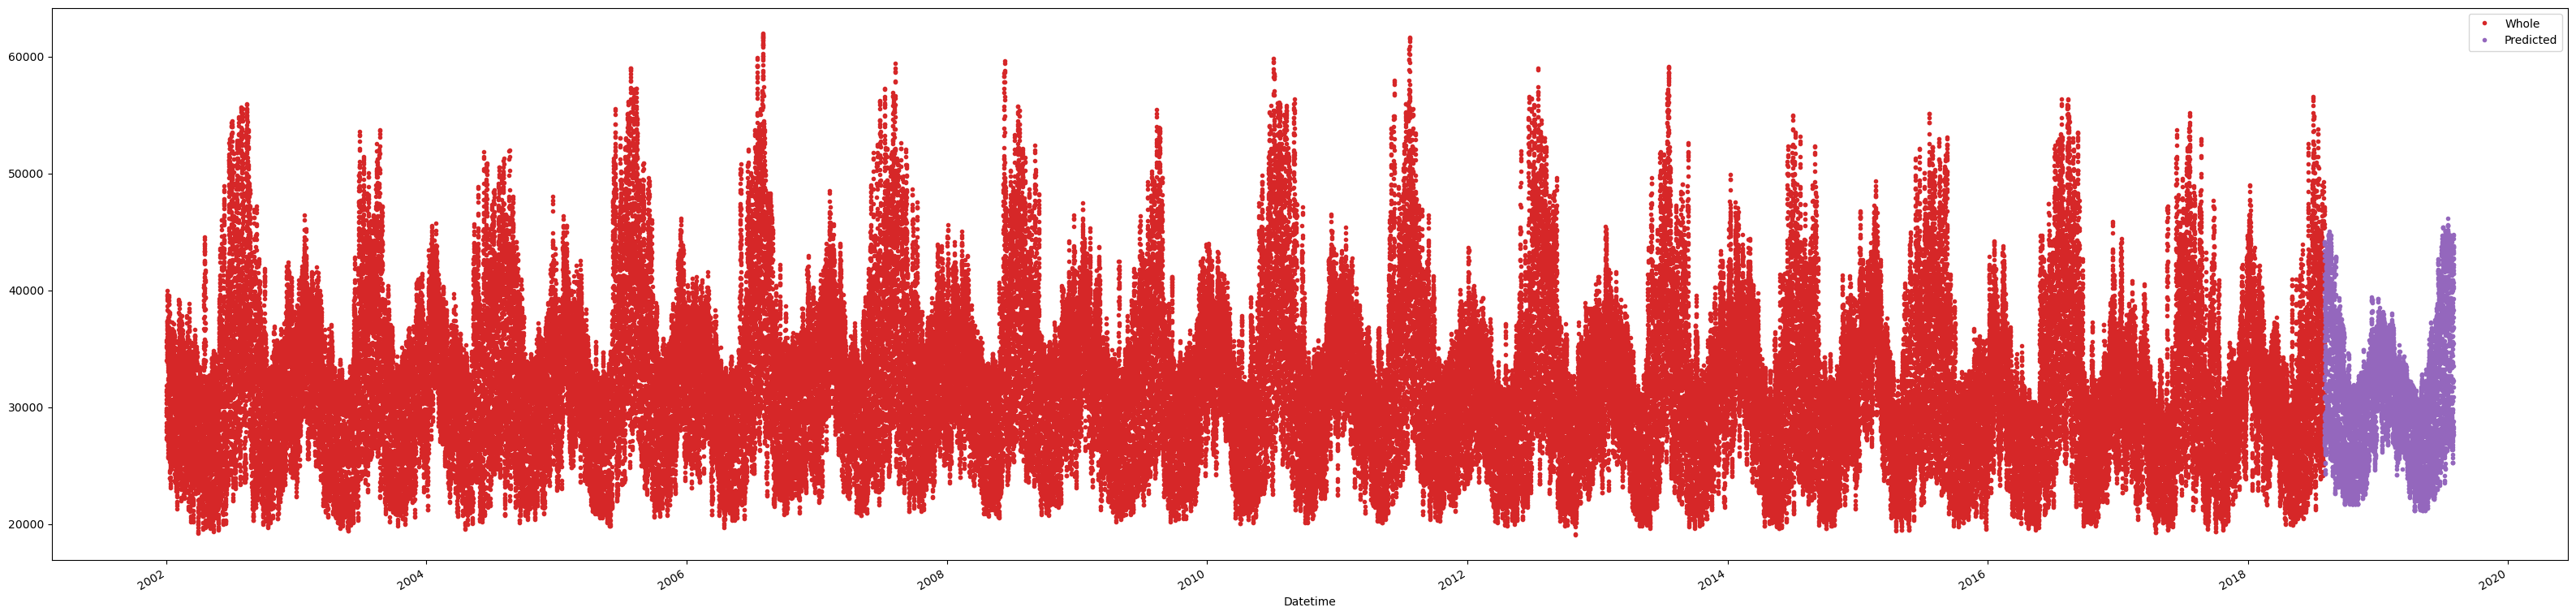

In [29]:
fig, ax = plt.subplots(figsize = (40,10))
df2['PJME_MW'].plot(ax = ax, style = '.', color= color_pal[3], label = 'Whole')
pred_future_data['PJME_MW'].plot(ax = ax, style = '.', color= color_pal[4], label = 'Predicted')
ax.legend(['Whole', 'Predicted'])
ax.plot()